**Выполнила Грищенко Анастасия**

# Проект: Статистический анализ данных

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 
Сервисом можно пользоваться:

без подписки:
      
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;
        
с подпиской Ultra:
      
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи - `users_go.csv`**

* `user_id` - универсальный идендификатор пользователя
* `name` - имя пользователя
* `age` - возраст
* `city` - город
* `subscription_type` - тип подписки(free, ultra)

**Поездки - `rides_go.csv`**

* `user_id` - уникальный идентификатор пользователя
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` - дата совершения поездки

**Подписки - `subscriptions_go.csv`**

* `subscription_type` - тип подписки
* `minute_price` - стоимость одной минуты поездки по данной подписке
* `start_ride_price` - стоимость начала поездки
* `subscription_fee` - стоимость ежемесячного платежа


#### Шаг 1. Загрузка данных

**1.1 Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

In [2]:
df_users_go = pd.read_csv('/datasets/users_go.csv')
df_rider_go = pd.read_csv('/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

**1.2 Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.**

In [3]:
# датафрейм Пользователи
df_users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
# датафрейм Поездки
df_rider_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
# датафрейм Подписки
df_subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**

Таблицы загрузились без ошибок. Пропуски отсутствуют во всех трех датафреймах.
В датафрейме Поездки (`rides_go.csv`) поле `date` имеет тип `object`.

#### Шаг 2. Предобработка данных

***Датафрейм Пользователи `users_go.csv`***

In [6]:
print('Сумма дубликатов: ', df_users_go.duplicated().sum())

Сумма дубликатов:  31


In [7]:
# удаляем дубликаты
df_users_go = df_users_go.drop_duplicates()
print('Количество явных дубликатов в датасете:', df_users_go.duplicated().sum())

Количество явных дубликатов в датасете: 0


In [8]:
# сумма пропусков
df_users_go.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

***Датафрейм Поездки `rides_go.csv`***

In [9]:
print('Сумма дубликатов: ', df_rider_go.duplicated().sum())

Сумма дубликатов:  0


In [10]:
# сумма пропусков
df_rider_go.isnull().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [11]:
# изменим тип в столбце 'date' на datetime
df_rider_go['date'] = pd.to_datetime(df_rider_go['date'], format='%Y-%m-%d')

# cоздадим новый столбец с номером месяца на основе столбца date
df_rider_go['month'] = df_rider_go['date'].dt.month
df_rider_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


***Датафрейм Подписки `subscriptions_go.csv`***

In [12]:
print('Сумма дубликатов: ', df_subscriptions_go.duplicated().sum())

Сумма дубликатов:  0


In [13]:
# сумма пропусков
df_subscriptions_go.isnull().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Вывод:**

В данном шаге проведена проведена предобработка данных. Проблема была обнаружена в датафрейме `users_go.csv` - 31 дубликат. Дубликаты были удалены. В остальных датафреймах дубликатов и пропусков не обнаружено.

Также в датафрейме `rides_go.csv` был изменен тип данных столбца `date' на `datetime`, а также создан дополнительный столбец с номером месяца.

#### Шаг 3. Исследовательский анализ данных

**3.1 частота встречаемости городов**

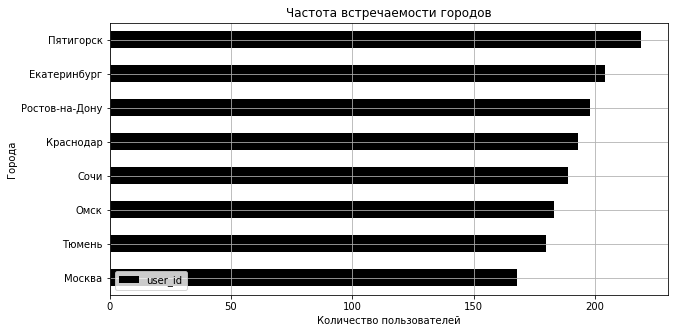

In [14]:
users_city = df_users_go.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
users_city = users_city.sort_values(by='user_id', ascending = True)
users_city.plot( kind='barh', figsize = (10,5),color='k', grid = True )
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.legend(loc='lower left')
plt.show()

#display(users_city.sort_values(by='user_id', ascending = False))

**Вывод:**

В данных представлены 8 городов: 
* Пятигорск -  219 пользователей, 
* Екатеринбург - 204 пользователей, 
* Ростов-на-Дону - 198 пользователей, 
* Краснодар - 193 пользователей, 
* Сочи - 189 пользователей, 
* Омск - 183 пользователей,
* Тюмень - 180 пользователей,
* Москва - 168 пользователей

Больше всего пользователей из города Пятигорск, а меньше всего из Москвы. 

**3.2 соотношение пользователей с подпиской и без подписки**

In [15]:
users_st = df_users_go.pivot_table(index = 'subscription_type', values = 'user_id', aggfunc = 'count').reset_index()

In [16]:
# столбчатая диаграмма

#users_st.plot(x = 'subscription_type', kind='barh', figsize = (10,5), color='k', grid = True )
#plt.title('Соотношение пользователей с подпиской и без подписки')
#plt.xlabel('Количество пользователей')
#plt.ylabel('Тип подписки')
#plt.show()

#users_st

<AxesSubplot:title={'center':'Соотношение пользователей с подпиской и без подписки'}, ylabel='user_id'>

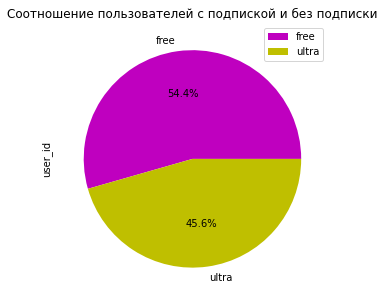

In [17]:
# круговая диаграмма
users_st.groupby(['subscription_type']).sum().plot(kind='pie', y='user_id', autopct='%1.1f%%', 
                                                      figsize = (10,5), colors = ['m', 'y'], 
                                                      title='Соотношение пользователей с подпиской и без подписки')

**Вывод:**

Без подписки  пользователей больше(835) - это 54.4%, чем с подпиской Ultra(699) - 45.6%.

**3.3 возраст пользователей**

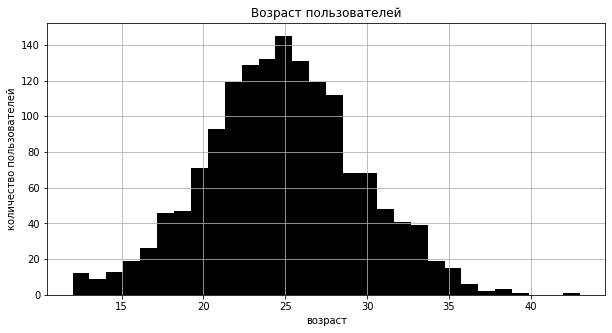

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [18]:
df_users_go['age'].plot(kind = 'hist', color='k', grid=True, figsize = (10,5), bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('возраст')
plt.ylabel('количество пользователей')
plt.show()

# высчитываем основные статистические характеристики
df_users_go['age'].describe()

**Вывод:**

Больше всего пользователей 25 лет. Медиана - 24,9, что доказывает наши выводы о графике.

**3.4 расстояние, которое пользователь преодолел за одну поездку**

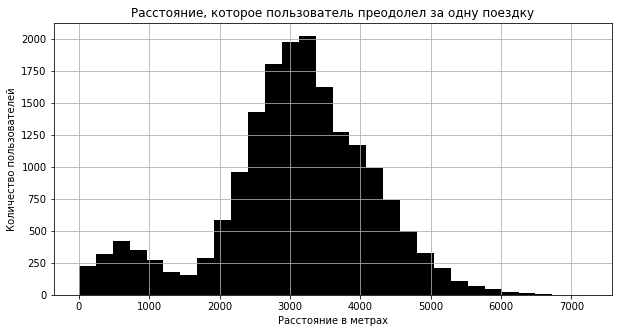

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [19]:
df_rider_go['distance'].plot(kind = 'hist', color='k', grid=True, figsize = (10,5), bins = 30)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.show()

# высчитываем основные статистические характеристики
df_rider_go['distance'].describe()

**Вывод:**

В среднем пользователель проезжает за одну поездку чуть больше 3-х киллометров.

**3.5 продолжительность поездок**

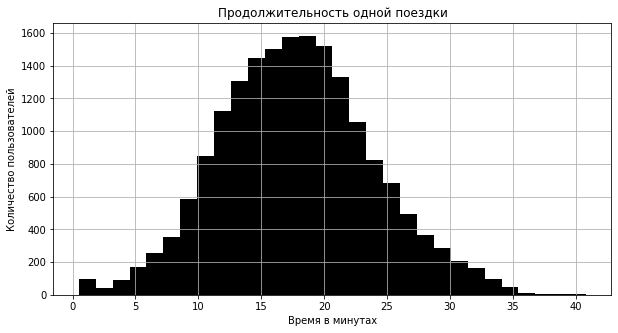

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [20]:
df_rider_go['duration'].plot(kind = 'hist', color='k', grid=True, figsize = (10,5), bins = 30)
plt.title('Продолжительность одной поездки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.show()

# высчитываем основные статистические характеристики
df_rider_go['duration'].describe()

**Вывод:**
    
Среднее время одной поездки 17.7 минут. Максимальное время поездки 40.8 минут.

#### Шаг 4. Объединение данных

**4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge()**

In [21]:
df_merge = df_rider_go.copy()
df_merge = df_merge.merge(df_users_go, on = 'user_id' )
df_merge = df_merge.merge(df_subscriptions_go, on='subscription_type')
df_merge.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


**4.2 Создайте ещё два датафрейма из датафрейма (`df_merge`), созданного на этапе 4.1:**

* **c данными о пользователях без подписки**
* **с данными о пользователях с подпиской**

In [22]:
df_merge_free = df_merge[df_merge['subscription_type'] == 'free']
df_merge_free.info()
df_merge_free.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [23]:
df_merge_ultra = df_merge[df_merge['subscription_type'] == 'ultra']
df_merge_ultra.info()
df_merge_ultra.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


<div class="alert alert-warning">
<b>⚠️ Комментарий ревьюера v1:</b> 
<br>Не забывай проверять размерность таблиц после любых операций с ними (создание, срезы, объединение). Это позволит понять, ничего ли не потерялось при объединении
</div>

**4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий**

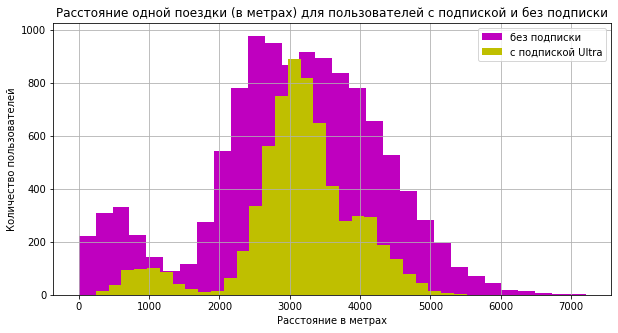

In [24]:
# визуализируем расстоение пользователей с подпиской и без подписки
ax = df_merge_free['distance'].plot(kind = 'hist',color='m', grid=True, figsize = (10,5), bins = 30, label='без подписки')
ax = df_merge_ultra['distance'].plot(kind = 'hist', color='y', grid=True, figsize = (10,5), bins = 30, label='с подпиской Ultra')
plt.title('Расстояние одной поездки (в метрах) для пользователей с подпиской и без подписки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()

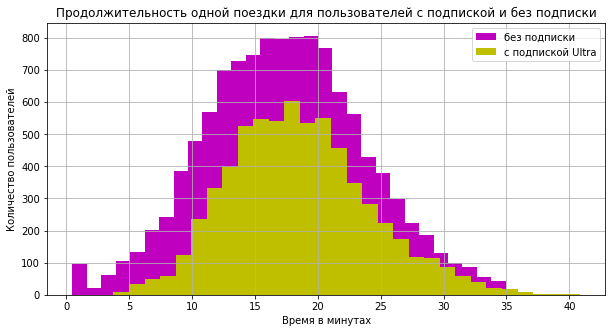

In [25]:
# визуализируем время поездок пользователей с подпиской и без подписки
ax = df_merge_free['duration'].plot(kind = 'hist',color='m', grid=True, figsize = (10,5), bins = 30, label='без подписки')
ax = df_merge_ultra['duration'].plot(kind = 'hist', color='y', grid=True, figsize = (10,5), bins = 30, label='с подпиской Ultra')
plt.title('Продолжительность одной поездки для пользователей с подпиской и без подписки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()


**Вывод:**

На данном этапе мы соеденили все три датафрейми, а потом разделили на два датафрейма: пользователи с подпиской Ultra и пользователей без подписки.

На двух сравнительных графиках по расстоянию и времени поездки мы видим различия в показателях. Так пользователи без подписки ездят на различные расстояния, когда пользователи с подпиской ездят на более длинные расстояния.
Время поездки у пользователей без подписки на графике отображено шире, чем у пользователей с подпиской. Тут можно сделать вывод, что люди чаще пользуются самокатом пару раз, для чего оформление подписки им не нужно.


#### Шаг 5. Подсчёт выручки

**5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц**

In [26]:
# округлим время поезки до следующего целого числа
df_merge['duration'] = np.ceil(df_merge['duration'])
df_merge['duration'] = df_merge['duration'].astype('int')

df_merge_agg = df_merge.pivot_table(index= ['user_id', 'month'], values = ['distance', 'duration'], aggfunc = ['count', 'sum'])
df_merge_agg.columns = ['_'.join(col) for col in df_merge_agg.columns.values]
df_merge_agg = df_merge_agg.drop(columns=['count_duration'])
df_merge_agg = df_merge_agg.reset_index()
df_merge_agg.head()

,user_id,month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56




* count_distance - количество поездок за месяц
* sum_distance - общая дистанция за месяц
* sum_duration - сумарное время пользователя за месяц (в минутах)



**5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26**


In [27]:
# соединяем датафреймы
df_merge_agg = df_merge_agg.merge(df_users_go, on='user_id')
df_merge_agg = df_merge_agg.merge(df_subscriptions_go, on='subscription_type')
df_merge_agg.head()

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199


In [28]:
# добавляем столбец с помесячной выручкой, которую принёс каждый пользователь
df_merge_agg['gain'] = (df_merge_agg['start_ride_price'] * df_merge_agg['count_distance'] 
                        + df_merge_agg['minute_price'] * df_merge_agg['sum_duration'] 
                        + df_merge_agg['subscription_fee']
                       )
df_merge_agg.head()

#df_merge_agg[['user_id', 'name', 'month', 'gain']] # сокращенный датафрейм

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,gain
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199,451
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199,241
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199,475
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199,391
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199,535


#### Шаг 6. Проверка гипотез

**Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.**

**6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.**

Сравним две выборки, df_merge_free и df_merge_ultra и проверим гипотезы:

    Нулевая теория: пользователи без подписки  и с подпиской тратят одинаковое времени на поездки
    Альтернативная гипотеза: пользователи: пользователи с подпиской тратят больше времени на поездки

In [29]:
# выбранный уровень статичстической значимости
alpha = 0.05

# проверяем правосторонюю альтернативную гипотезу
results = st.ttest_ind(df_merge_ultra['duration'], df_merge_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [30]:
# делаем проверку
print(f'Среднее поездки пользователей с подпиской: {np.mean(df_merge_ultra.duration)}')
print(f'Среднее поездки пользователей без подпиской: {np.mean(df_merge_free.duration)}')

Среднее поездки пользователей с подпиской: 18.54198516280583
Среднее поездки пользователей без подпиской: 17.39090929866399


*Гипотеза верна: среднее время поездок пользователей с подпиской больше, чем время поездок пользователей без подписки.*

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.**

Проверим гипотезы:

    Нулевая гипотеза: среднее расстояние поездки пользователи с подпиской равна 3130 метрам
    Альтернативная гипотеза:  среднее расстояние поездки пользователи с подпиской меньше 3130 метров

In [31]:
# расстояние одной поездки в метрах
interested_value = 3130 

# выбранный уровень статичстической значимости
alpha = 0.05 

# проверяем правосторонюю альтернативную гипотезу
results = st.ttest_1samp(df_merge_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [32]:
# делаем проверку
print(f'Среднее расстояние поездки пользователей c подпиской: {np.mean(df_merge_ultra.distance)}')

Среднее расстояние поездки пользователей c подпиской: 3115.4453880370247


*Гипотеза верна: среднее расстояние поездки пользователей с подпиской меньше, чем 3130 метров.*

**6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.**

Проверим гипотезы:

    Нулевая гипотеза: помесячная выручка от пользователей с подпиской и без подписки равны.
    Альтернативная гипотеза: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

In [33]:
# создаем две выборки с помесячной выручкой 
df_merge_agg_ultra = df_merge_agg[df_merge_agg['subscription_type'] == 'ultra']
df_merge_agg_free = df_merge_agg[df_merge_agg['subscription_type'] == 'free']

# выбранный уровень статичстической значимости
alpha = 0.05

# проверяем правосторонюю альтернативную гипотезу
results = st.ttest_ind(df_merge_agg_ultra['gain'], df_merge_agg_free['gain'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [34]:
# делаем проверку
print(f'Средняя помесячная выручка от пользователи с подпиской: {np.mean(df_merge_agg_ultra.gain)}')
print(f'Средняя помесячная выручка от пользователи без подписки:{np.mean(df_merge_agg_free.gain)}')

Средняя помесячная выручка от пользователи с подпиской: 362.7921906022502
Средняя помесячная выручка от пользователи без подписки:328.6413651073845


*Гипотеза верна: средняя помесячная выручка от пользователей с подпиской больше, что от пользователей без подписки.*

**6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

В данном случае правильнее применить двухвыборочный t-тест для зависимых выборок. В метод st.ttest_rel() нужно передать две выборки: наборы данных до обновления и после.

**ИТОГОВЫЙ ВЫВОД:**

При статистическом анализе данных нам удалость выяснить:

* Больше всего пользователей из города Пятигорск (219), а меньше всего из Москвы (168);
* Без подписки пользователей больше(835) - это 54.4%, чем с подпиской Ultra(699) - 45.6%;
* Больше всего пользователей 25 лет. Медиана - 24,9, что доказывает наши выводы о графике;
* В среднем пользователель проезжает за одну поездку чуть больше 3-х киллометров;
* Среднее время одной поездки 17.7 минут. Максимальное время поездки 40.8 минут;

В ходе исследования были подтверждены следующие гипотезы:

* среднее время поездок пользователей с подпиской больше, чем время поездок пользователей без подписки;
* среднее расстояние поездки пользователей с подпиской меньше, чем 3130 метров;
* средняя помесячная выручка от пользователей с подпиской больше, что от пользователей без подписки.


